# Day 2, session 3: Detecting features in Hi-C maps

In this session we will be looking at ways to automatically find regions with features of interest.
This includes both supervised and unsupervised methods depending on the question.

## Unsupervised detection

### Differential contacts
The classic approach, much like in differential gene expression analysis, is to look at regions with differing contact counts.
There are some well established tools to do this type of analyses, like diffhic or ACCOST.

### Structural changes

A more recent approach, implemented as CHESS (python package chess-hic) uses the notion of structural changes. This is also unsupervised, but attempts to find differential features as "vignettes" in the map.

Those features can then be clustered by similarity so that the user can identify what they represent (loops, stripes, borders, ...)
More info about CHESS in the official docs: https://chess-hic.readthedocs.io/en/latest/?badge=latest

## Supervised pattern detection

There are many methods to detect a specific type of pattern, especially loops and TADS.
Most of those softwares are listed here: https://github.com/mdozmorov/HiC_tools#loop-callers


### Chromosight

Much like other tools, Chromosight can detect patterns in Hi-C contact maps. Instead of being limited to loops or TADS, it uses template matching (a computer vision algorithm) to detect various patterns.

More info about chromosight in the official docs: https://chromosight.readthedocs.io/en/latest/

In [ ]:
%%bash
MESC=data/4DNFI9FPCAC7_G0G1_mESC_sub.cool
NPC=data/4DNFIEB68WXR_G0G1_NPC_sub.cool
chromosight detect -w npy --pattern=borders $MESC data/borders_mesc
chromosight detect -w npy --pattern=borders $NPC data/borders_npc

## Using external tracks

Often instead of detecting those features solely from the Hi-C signal, we use external tracks such as ChIP-seq of proteins of interest to find the regions.

This can be used for example to train machine learning methods such as [Peakachu](https://github.com/tariks/peakachu)

There are also helpful tools like [coolpuppy](https://github.com/open2c/coolpuppy) which can do 2D aggregation of Hi-C maps using 1D signals spaced by 50kb to 1Mb. Here is an example where we use it to aggregate combinations of Nanog peaks. Nanog is a homeobox protein that helps maintain pluripotency, here we'll check whether sites bound by nanog interact differently between ES cells and NPC.


In [18]:
%%bash
coolpup.py --maxdist 1000000 \
           --mindist 50000 \
           data/4DNFI9FPCAC7_G0G1_mESC_sub.cool \
           data/ENCFF557KRT_nanog_chip_mm10.bed

Namespace(anchor=None, baselist='data/ENCFF557KRT_nanog_chip_mm10.bed', bed2=None, bed2_ordered=True, by_window=False, coolfile='data/4DNFI9FPCAC7_G0G1_mESC_sub.cool', coverage_norm=False, excl_chrs='chrY,chrM', expected=None, ignore_diags=2, incl_chrs='all', local=False, logLevel='INFO', maxdist=2000000, maxshift=1000000, maxsize=None, mindist=1000000, minshift=100000, minsize=None, n_proc=1, nshifts=10, outdir='.', outname='auto', pad=100, post_mortem=False, rescale=False, rescale_pad=1.0, rescale_size=99, save_all=False, seed=None, subset=0, unbalanced=False, weight_name='weight')
NumExpr defaulting to 2 threads.
chr1: 2314
chr2: 2466
chr3: 1337
chr4: 1876
chr5: 2193
chr6: 1708
chr7: 1276
chr8: 1495
chr9: 1819
chr10: 1634
chr11: 2269
chr12: 1138
chr13: 1593
chr14: 1433
chr15: 1194
chr16: 969
chr17: 1238
chr18: 1054
chr19: 1039
chrX: 311
Total number of piled up windows: 30356
chr1: 23128
chr2: 24545
chr3: 13349
chr4: 18743
chr5: 21923
chr6: 17064
chr7: 12759
chr8: 14947
chr9: 18167


<IPython.core.display.Javascript object>


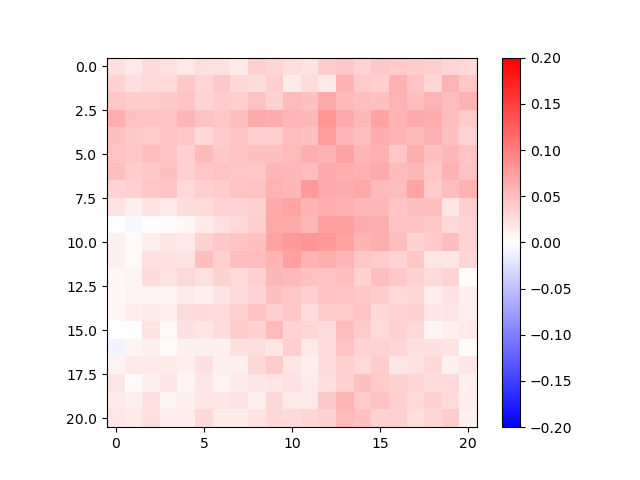

In [23]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
pu = np.loadtxt('./4DNFI9FPCAC7_G0G1_mESC_sub-10.0K_over_ENCFF557KRT_nanog_chip_mm10_10-shifts_dist_50000-1000000.np.txt')
plt.imshow(np.log2(pu), cmap='bwr', vmin=-.2, vmax=.2)
plt.colorbar()

Chromosight can also quantify correlation scores with a given pattern at 2D positions given by a BED2D file.

In [ ]:
%%bash
# We first need to get 1D positions into 2D combinations
# E.g. to generate all combinations of positions spaced by more than 50kb but less than 1Mb:

MINDIST=50000
MAXDIST=1000000
BED=data/ENCFF557KRT_nanog_chip_mm10.bed

bedtools window -a $BED -b $BED -w $MAXDIST |
    awk -vmd=$MINDIST '$1 == $4 && ($5 - $2) >= md {print}' |
    sort -k1,1 -k2,2n -k4,4 -k5,5n > data/ENCFF557KRT_nanog_chip_mm10.bed2d

Now we can quantify loop scores at those combination of nanog sites between the two conditions:

In [ ]:
%%bash
NANOG=data/ENCFF557KRT_nanog_chip_mm10.bed2d
MESC=data/4DNFI9FPCAC7_G0G1_mESC_sub.cool
NPC=data/data/4DNFIEB68WXR_G0G1_NPC_sub.cool
chromosight quantify -w npy --pattern=loops $NANOG $MESC loops_nanog_mesc
chromosight quantify -w npy --pattern=loops $NANOG $NPC  loops_nanog_npc

To load the tabular output, we can use pandas dataframes:

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
mesc_loops = pd.read_csv('data/chromosight/loops_nanog_mesc.tsv', sep='\t')
npc_loops = pd.read_csv('data/chromosight/loops_nanog_npc.tsv', sep='\t')
npc_loops.head()

,chrom1,start1,end1,chrom2,start2,end2,bin1,bin2,score,pvalue,qvalue
0,chr1,3062838,3063099,chr1,3343600,3343832,306.0,334.0,NaN,NaN,NaN
1,chr1,3062838,3063099,chr1,3344163,3344527,306.0,334.0,NaN,NaN,NaN
2,chr1,3062838,3063099,chr1,3482839,3483203,306.0,348.0,NaN,NaN,NaN
3,chr1,3062838,3063099,chr1,3648984,3649348,306.0,364.0,NaN,NaN,NaN
4,chr1,3062838,3063099,chr1,3946985,3947349,306.0,394.0,NaN,NaN,NaN


> Comparing distribution of loop scores does not reveal major differences.

<IPython.core.display.Javascript object>


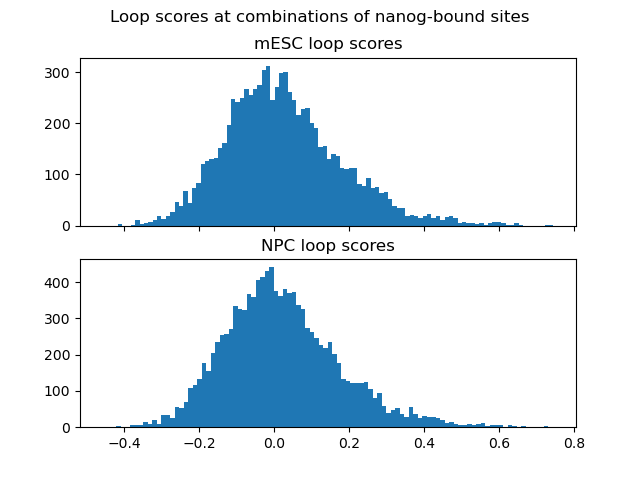

Text(0.5, 0.98, 'Loop scores at combinations of nanog-bound sites')

In [27]:
%matplotlib notebook
fig, ax = plt.subplots(2, 1, sharex=True)
_ = ax[0].hist(mesc_loops.score, 100)
_ = ax[1].hist(npc_loops.score, 100)
ax[0].set_title("mESC loop scores")
ax[1].set_title("NPC loop scores")
plt.suptitle("Loop scores at combinations of nanog-bound sites")

Let's import the individual matrix slices around those combinations to inspect them separately at different distances.

In [28]:
mesc_imgs = np.load('data/chromosight/loops_nanog_mesc.npy')
npc_imgs = np.load('data/chromosight/loops_nanog_npc.npy')

<IPython.core.display.Javascript object>


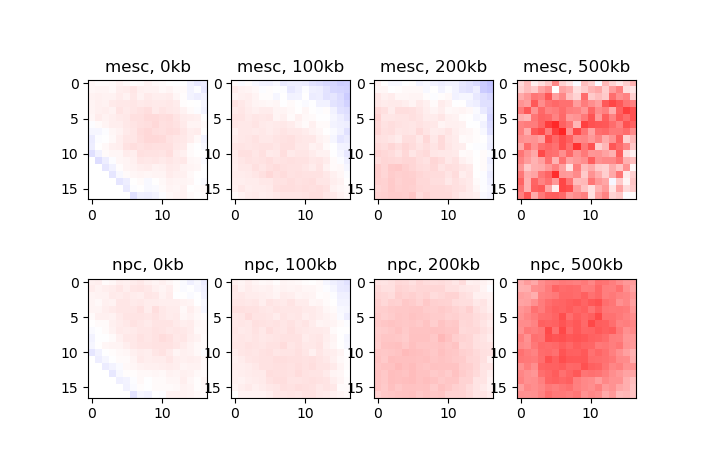

/home/ubuntu/miniconda3/envs/epi2021/lib/python3.8/site-packages/numpy/lib/shape_base.py:402: RuntimeWarning: Mean of empty slice
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


In [29]:
%matplotlib notebook
dist_ranges = [0, 100000, 200000, 500000, 2000000]
loop_sizes = np.abs(mesc_loops.start2 - mesc_loops.start1)

pileup = lambda arr: np.apply_along_axis(np.nanmean, 0, arr)

fig, ax = plt.subplots(2, len(dist_ranges)-1)
for i in range(len(dist_ranges)-1):
    # Check which loops are in the distance range
    in_range = (loop_sizes >= dist_ranges[i]) & (loop_sizes < dist_ranges[i+1])
    # Compute pileups (average image stacks)
    mesc_pu = pileup(mesc_imgs[in_range, :, :])
    npc_pu = pileup(npc_imgs[in_range, :, :])
    # Plot heatmaps for each distance range
    ax[0, i].imshow(np.log2(mesc_pu), cmap='bwr', vmin=-1, vmax=1)
    ax[1, i].imshow(np.log2(npc_pu), cmap='bwr', vmin=-1, vmax=1)
    # Add title to heatmaps
    ax[0, i].set_title(f'mesc, {int(dist_ranges[i]/1000)}kb')
    ax[1, i].set_title(f'npc, {int(dist_ranges[i]/1000)}kb')

> How do those results compare with Figure S7, panel A of [Bonev et al, 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5651218/) ?

> Based on that, what range would you use in coolpuppy ? Does it help ?